In [1]:
# ============================================
# FAKE NEWS DETECTOR — IBM SkillsBuild Project
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import warnings
warnings.filterwarnings('ignore')

# NLP
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load the datasets
fake_df = pd.read_csv('/content/Fake.csv')
true_df = pd.read_csv('/content/True.csv')

# Add labels
fake_df['label'] = 0   # 0 = Fake
true_df['label'] = 1   # 1 = Real

# Preview
print("FAKE news shape:", fake_df.shape)
print("REAL news shape:", true_df.shape)
print("\n--- Fake News Sample ---")
fake_df.head(3)

FAKE news shape: (23481, 5)
REAL news shape: (21417, 5)

--- Fake News Sample ---


,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0


In [3]:
# Merge both dataframes
df = pd.concat([fake_df, true_df], ignore_index=True)

# Shuffle the data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("✅ Combined dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nColumns:", df.columns.tolist())
df.head()

✅ Combined dataset shape: (44898, 5)

Label distribution:
label
0    23481
1    21417
Name: count, dtype: int64

Columns: ['title', 'text', 'subject', 'date', 'label']


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [4]:
# Check for missing values
print("Null values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

Null values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64

Data types:
 title      object
text       object
subject    object
date       object
label       int64
dtype: object


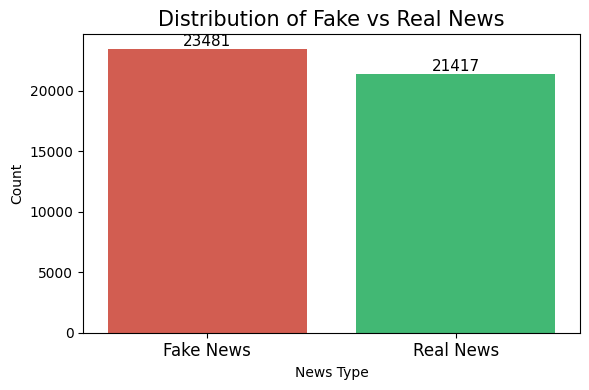

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette=['#e74c3c', '#2ecc71'])
plt.xticks([0,1], ['Fake News', 'Real News'], fontsize=12)
plt.title('Distribution of Fake vs Real News', fontsize=15)
plt.ylabel('Count')
plt.xlabel('News Type')
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width()/2, p.get_height()),
                       ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

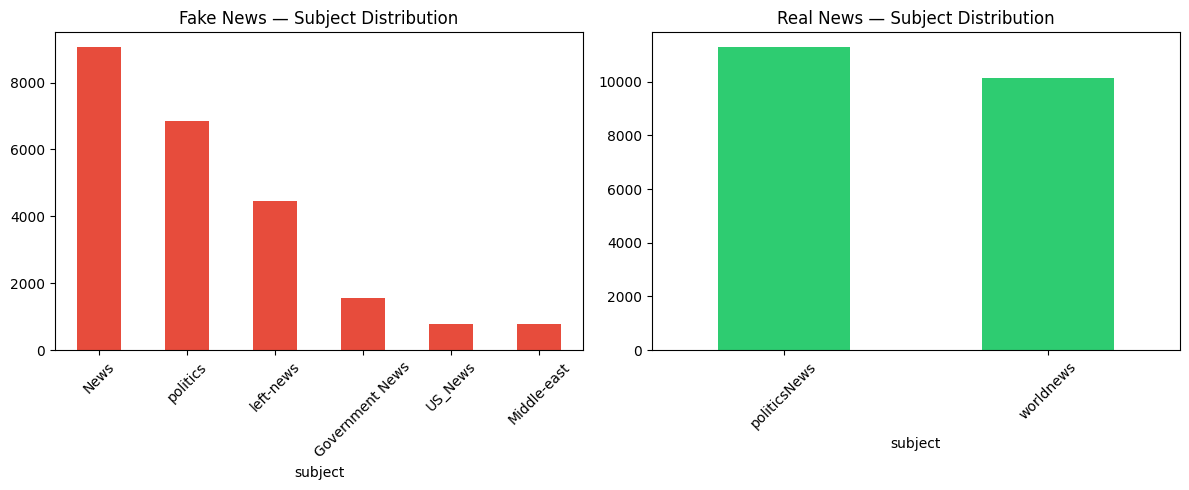

In [6]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
fake_df['subject'].value_counts().plot(kind='bar', color='#e74c3c')
plt.title('Fake News — Subject Distribution')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
true_df['subject'].value_counts().plot(kind='bar', color='#2ecc71')
plt.title('Real News — Subject Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

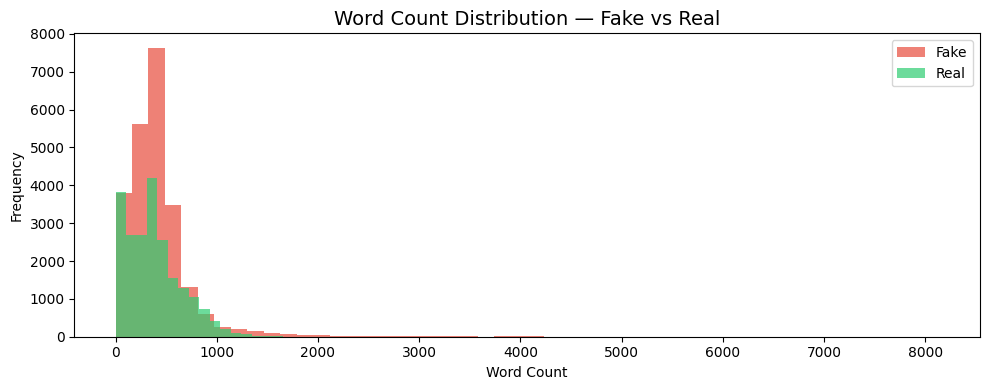

Avg word count - Fake: 423.2
Avg word count - Real: 385.64


In [7]:
# Add word count column
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,4))
df[df['label']==0]['word_count'].plot(kind='hist', bins=50,
                                       alpha=0.7, color='#e74c3c', label='Fake')
df[df['label']==1]['word_count'].plot(kind='hist', bins=50,
                                       alpha=0.7, color='#2ecc71', label='Real')
plt.title('Word Count Distribution — Fake vs Real', fontsize=14)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

print("Avg word count - Fake:", df[df['label']==0]['word_count'].mean().round(2))
print("Avg word count - Real:", df[df['label']==1]['word_count'].mean().round(2))

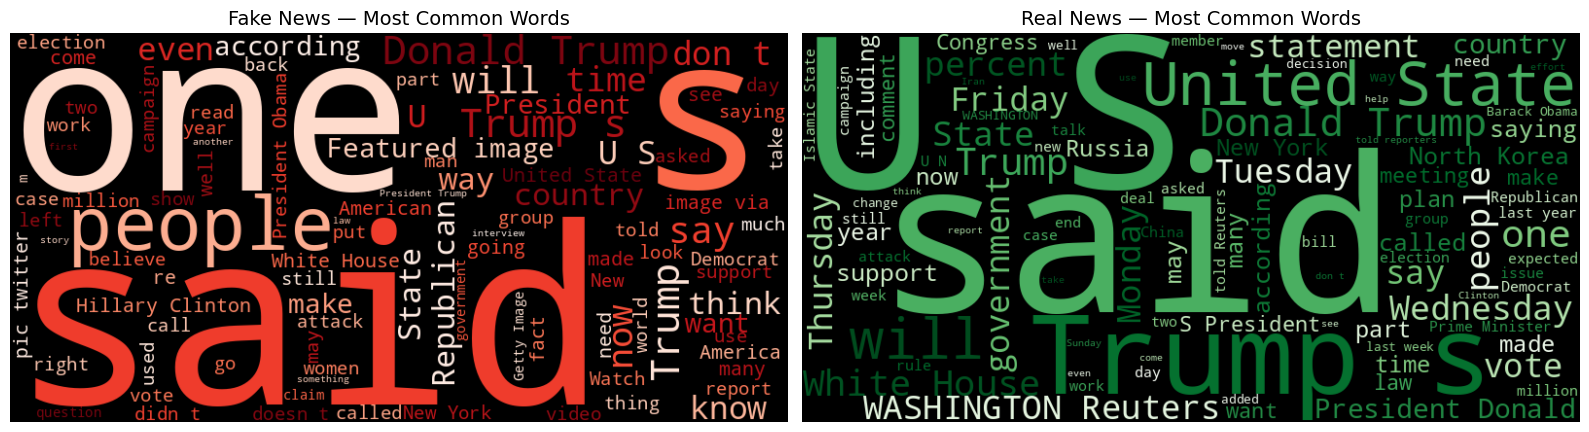

In [8]:
from wordcloud import WordCloud

# Fake news wordcloud
fake_text = ' '.join(df[df['label']==0]['text'].astype(str).tolist())
real_text = ' '.join(df[df['label']==1]['text'].astype(str).tolist())

fig, axes = plt.subplots(1, 2, figsize=(16,6))

wc_fake = WordCloud(width=800, height=400,
                    background_color='black',
                    colormap='Reds',
                    max_words=100).generate(fake_text)

wc_real = WordCloud(width=800, height=400,
                    background_color='black',
                    colormap='Greens',
                    max_words=100).generate(real_text)

axes[0].imshow(wc_fake, interpolation='bilinear')
axes[0].set_title('Fake News — Most Common Words', fontsize=14)
axes[0].axis('off')

axes[1].imshow(wc_real, interpolation='bilinear')
axes[1].set_title('Real News — Most Common Words', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [9]:
# Combine title and text for more info
df['content'] = df['title'] + ' ' + df['text']

# Initialize stemmer and stopwords
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    words = text.split()

    # Remove stopwords and apply stemming
    words = [ps.stem(word) for word in words if word not in stop_words]

    return ' '.join(words)

print("✅ Cleaning function defined!")
print("Sample before cleaning:\n", df['content'][0][:200])

✅ Cleaning function defined!
Sample before cleaning:
 Ben Stein Calls Out 9th Circuit Court: Committed a ‘Coup d’état’ Against the Constitution 21st Century Wire says Ben Stein, reputable professor from, Pepperdine University (also of some Hollywood fame


In [10]:
print("⏳ Cleaning text... please wait...")
df['cleaned_content'] = df['content'].apply(clean_text)
print("✅ Text cleaning done!")
print("\nSample after cleaning:\n", df['cleaned_content'][0][:200])

⏳ Cleaning text... please wait...
✅ Text cleaning done!

Sample after cleaning:
 ben stein call th circuit court commit coup dtat constitut st centuri wire say ben stein reput professor pepperdin univers also hollywood fame appear tv show film ferri bueller day made provoc stateme


In [11]:
X = df['cleaned_content']
y = df['label']

print("✅ Features and labels ready!")
print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nLabel counts:\n", y.value_counts())

✅ Features and labels ready!
X shape: (44898,)
y shape: (44898,)

Label counts:
 label
0    23481
1    21417
Name: count, dtype: int64


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data split done!")
print("Training size:", X_train.shape[0])
print("Testing size:", X_test.shape[0])

✅ Data split done!
Training size: 35918
Testing size: 8980


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("✅ TF-IDF Vectorization done!")
print("Training matrix shape:", X_train_tfidf.shape)
print("Testing matrix shape:", X_test_tfidf.shape)

✅ TF-IDF Vectorization done!
Training matrix shape: (35918, 5000)
Testing matrix shape: (8980, 5000)


In [14]:
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Passive Aggressive": PassiveAggressiveClassifier()
}

results = {}

for name, model in models.items():
    print(f"⏳ Training {name}...")
    model.fit(X_train_tfidf, y_train)
    pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, pred)
    results[name] = acc
    print(f"✅ {name} — Accuracy: {acc*100:.2f}%\n")

print("🏆 All models trained!")

⏳ Training Logistic Regression...
✅ Logistic Regression — Accuracy: 98.54%

⏳ Training Decision Tree...
✅ Decision Tree — Accuracy: 99.52%

⏳ Training Random Forest...
✅ Random Forest — Accuracy: 99.74%

⏳ Training Passive Aggressive...
✅ Passive Aggressive — Accuracy: 99.35%

🏆 All models trained!


In [15]:
from sklearn.ensemble import GradientBoostingClassifier

print("⏳ Training Gradient Boosting... (this will take a while, be patient!)")

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_tfidf, y_train)

gb_pred = gb_model.predict(X_test_tfidf)
gb_acc = accuracy_score(y_test, gb_pred)

print(f"✅ Gradient Boosting — Accuracy: {gb_acc*100:.2f}%")
print(f"\n🏆 Random Forest was: 99.68%")
print(f"🆕 Gradient Boosting is: {gb_acc*100:.2f}%")

if gb_acc > 0.9968:
    print("\n🎉 Gradient Boosting BEATS Random Forest!")
else:
    print("\n👑 Random Forest is still the CHAMPION!")

⏳ Training Gradient Boosting... (this will take a while, be patient!)
✅ Gradient Boosting — Accuracy: 99.54%

🏆 Random Forest was: 99.68%
🆕 Gradient Boosting is: 99.54%

👑 Random Forest is still the CHAMPION!


In [16]:
import pickle

# Define best model explicitly
best_model = models["Random Forest"]

# Save the Random Forest model
with open('fake_news_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("✅ Model saved as: fake_news_model.pkl")
print("✅ TF-IDF saved as: tfidf_vectorizer.pkl")

✅ Model saved as: fake_news_model.pkl
✅ TF-IDF saved as: tfidf_vectorizer.pkl


In [17]:
# Load and test
with open('fake_news_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_tfidf = pickle.load(f)

# Test with a sample
sample = ["Donald Trump says he will make America great again with new policy"]
sample_cleaned = [clean_text(sample[0])]
sample_tfidf = loaded_tfidf.transform(sample_cleaned)

# Prediction
prediction = loaded_model.predict(sample_tfidf)

# Confidence %
proba = loaded_model.predict_proba(sample_tfidf)[0]
fake_percent = round(proba[0] * 100, 2)
real_percent = round(proba[1] * 100, 2)

print("📰 Sample News:", sample[0])
print("─" * 50)
if prediction[0] == 1:
    print(f"🔍 Prediction: ✅ REAL News")
else:
    print(f"🔍 Prediction: ❌ FAKE News")
print(f"📊 Confidence:")
print(f"   🔴 Fake: {fake_percent}%")
print(f"   🟢 Real: {real_percent}%")

📰 Sample News: Donald Trump says he will make America great again with new policy
──────────────────────────────────────────────────
🔍 Prediction: ❌ FAKE News
📊 Confidence:
   🔴 Fake: 97.0%
   🟢 Real: 3.0%


In [56]:
app_code = '''
import streamlit as st
import pickle
import re
import os
import gdown
import nltk
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# ─── LOAD MODEL FROM GOOGLE DRIVE ───
@st.cache_resource
def load_models():
    if not os.path.exists("fake_news_model.pkl"):
        gdown.download("https://drive.google.com/uc?id=19I5C6UAXWTsA4kLGJ0wrJlXS0llYQril",
                      "fake_news_model.pkl", quiet=False)
    if not os.path.exists("tfidf_vectorizer.pkl"):
        gdown.download("https://drive.google.com/uc?id=1veVtaxDh8BsX7C78n2To8DUlB_bRjob9",
                      "tfidf_vectorizer.pkl", quiet=False)

    with open("fake_news_model.pkl", "rb") as f:
        model = pickle.load(f)
    with open("tfidf_vectorizer.pkl", "rb") as f:
        tfidf = pickle.load(f)
    return model, tfidf

model, tfidf = load_models()

# ─── CLEAN FUNCTION ───
ps = PorterStemmer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"https?://\\S+|www\\.\\S+", "", text)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^a-zA-Z\\s]", "", text)
    words = text.split()
    words = [ps.stem(w) for w in words if w not in stop_words]
    return " ".join(words)

# ─── PAGE CONFIG ───
st.set_page_config(page_title="Fake News Detector", page_icon="📰", layout="centered")

# ─── CUSTOM CSS ───
st.markdown("""
<style>
.stTextArea textarea {
    background-color: #ffffff !important;
    color: #000000 !important;
    font-size: 16px !important;
    border: 2px solid #4a90e2 !important;
    border-radius: 10px !important;
}
.stButton > button {
    background-color: #4a90e2;
    color: white;
    font-size: 18px;
    font-weight: bold;
    border-radius: 10px;
    width: 100%;
    border: none;
}
</style>
""", unsafe_allow_html=True)

# ─── HEADER ───
st.markdown("<h1 style=\\'text-align:center;\\'>📰 Fake News Detector</h1>", unsafe_allow_html=True)
st.markdown("<p style=\\'text-align:center; color:gray;\\'>Powered by Random Forest & NLP | IBM SkillsBuild Project</p>", unsafe_allow_html=True)
st.markdown("---")

# ─── INPUT ───
st.markdown("### 📝 Enter News Article or Headline:")
news = st.text_area("", height=200, placeholder="Paste your news text here...")

# ─── PREDICT ───
if st.button("🔍 Check News"):
    if news.strip() == "":
        st.warning("⚠️ Please enter some news text first!")
    else:
        with st.spinner("🔍 Analyzing..."):
            cleaned = clean_text(news)
            vectorized = tfidf.transform([cleaned])
            prediction = model.predict(vectorized)[0]
            proba = model.predict_proba(vectorized)[0]
            fake_pct = round(proba[0] * 100, 2)
            real_pct = round(proba[1] * 100, 2)

        st.markdown("---")
        if prediction == 1:
            st.success("✅ This news appears to be REAL!")
        else:
            st.error("❌ This news appears to be FAKE!")

        st.markdown("### 📊 Confidence Score")
        col1, col2 = st.columns(2)
        with col1:
            st.metric("🔴 Fake Probability", f"{fake_pct}%")
            st.progress(fake_pct / 100)
        with col2:
            st.metric("🟢 Real Probability", f"{real_pct}%")
            st.progress(real_pct / 100)

        st.markdown("---")
        st.caption("⚠️ This tool is for educational purposes only.")
'''

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py updated with Google Drive links!")

✅ app.py updated with Google Drive links!


In [57]:
requirements = """streamlit
scikit-learn
nltk
pandas
numpy
gdown
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

print("✅ requirements.txt created!")

✅ requirements.txt created!


In [58]:
from google.colab import files
files.download('app.py')
files.download('requirements.txt')
print("✅ Downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Downloaded!
